In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.cm as cm
import time

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
#Reshaping and rescaling x
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train2 = x_train.reshape(60000,784)
x_test2 = x_test.reshape(10000,784)

In [4]:
#One-hot-encoded versions of the labels
y_train2 = keras.utils.to_categorical(y_train, num_classes=10)
y_test2 = keras.utils.to_categorical(y_test, num_classes=10)

# 2a

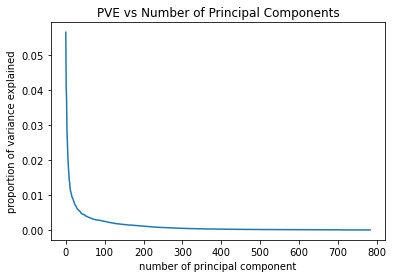

In [5]:
normalised = preprocessing.scale(x_train2)

pca = PCA()
pca.fit(normalised)
plt.plot(pca.explained_variance_ratio_)
plt.title("PVE vs Number of Principal Components")
plt.xlabel('number of principal component')
plt.ylabel('proportion of variance explained')
#plt.savefig('2a1.png',bbox_inches='tight')
plt.show()

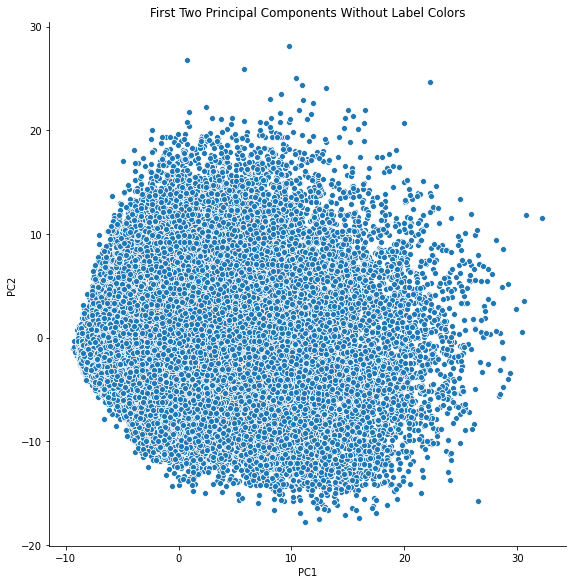

In [6]:
X_transformed = pca.transform(normalised)
trans= pd.DataFrame(X_transformed)
trans["label"]=y_train
sns.FacetGrid(trans, height = 8).map(sns.scatterplot, 0, 1).add_legend()
plt.title("First Two Principal Components Without Label Colors")
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig('2a2.png',bbox_inches='tight')
plt.show()

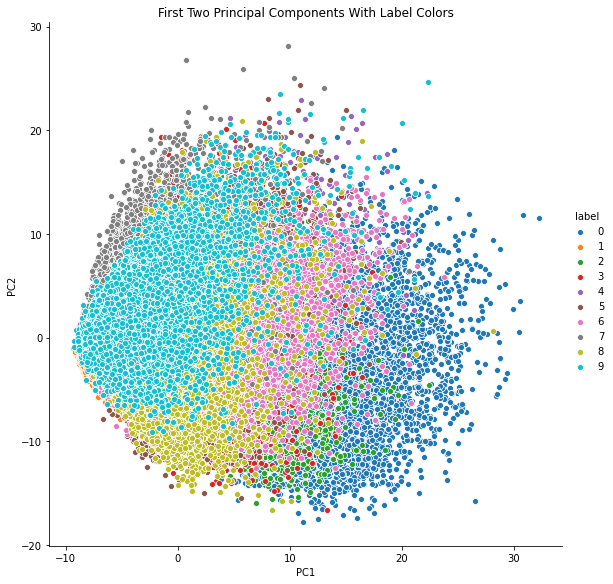

In [7]:
sns.FacetGrid(trans, hue = 'label', height = 8).map(sns.scatterplot, 0, 1).add_legend()
plt.title("First Two Principal Components With Label Colors")
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig('2a3.png',bbox_inches='tight')
plt.show()

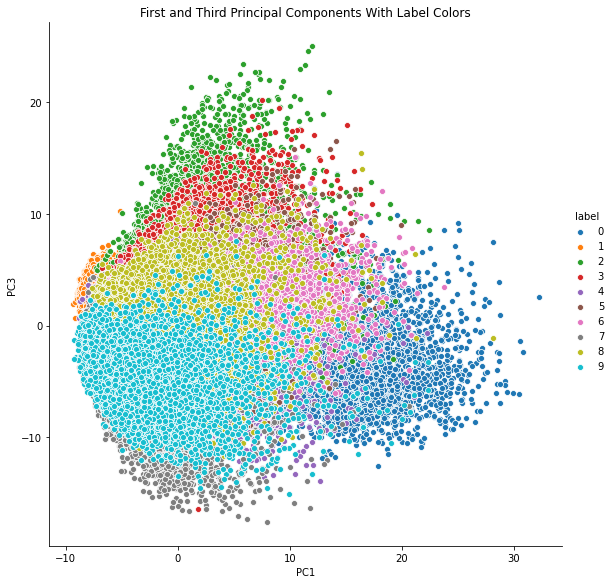

In [8]:
sns.FacetGrid(trans, hue = 'label', height = 8).map(sns.scatterplot, 0, 2).add_legend()
plt.title("First and Third Principal Components With Label Colors")
plt.xlabel('PC1')
plt.ylabel('PC3')
#plt.savefig('2a5.png',bbox_inches='tight')
plt.show()

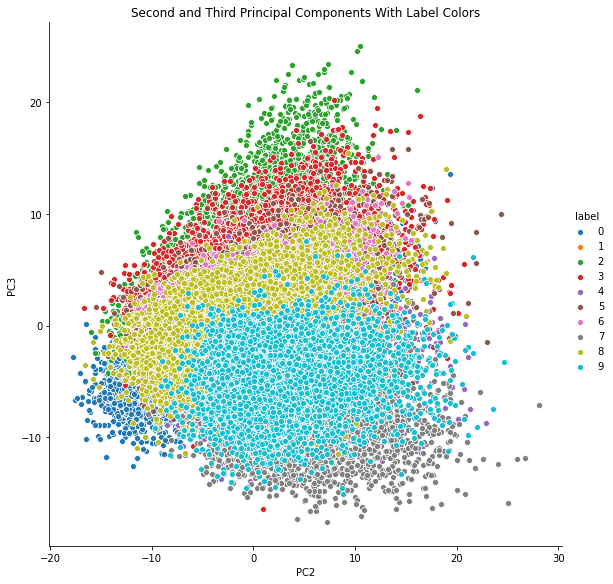

In [9]:
sns.FacetGrid(trans, hue = 'label', height = 8).map(sns.scatterplot, 1, 2).add_legend()
plt.title("Second and Third Principal Components With Label Colors")
plt.xlabel('PC2')
plt.ylabel('PC3')
#plt.savefig('2a6.png',bbox_inches='tight')
plt.show()

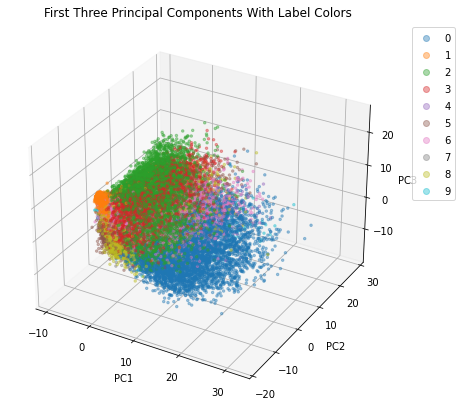

In [10]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
scatter= ax.scatter(trans.loc[:,0], trans.loc[:,1], trans.loc[:,2], c=trans.loc[:,"label"], s=6,cmap=cm.tab10,alpha=0.4)
ax.set_title("First Three Principal Components With Label Colors")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

#plt.savefig('2a4.png',bbox_inches='tight')
plt.show()

# 3b

In [11]:
# Random sampling from data (%10)
idx = np.random.choice(x_train2.shape[0], 6000, replace=False)
s_xtrain=x_train2[idx, :]
s_ytrain=y_train[idx]

idx2 = np.random.choice(x_test2.shape[0], 1000, replace=False)
s_xtest=x_test2[idx2, :]
s_ytest=y_test[idx2]

**Linear SVC**

In [12]:
model = SVC(kernel='linear')
model.fit(s_xtrain, s_ytrain)

SVC(kernel='linear')

In [13]:
print('Accuracy on test set:',model.score(s_xtest,s_ytest))

Accuracy on test set: 0.921


**Poly kernel**

In [14]:
model2 = SVC(kernel = 'poly', degree = 2)
model2.fit(s_xtrain, s_ytrain)

SVC(degree=2, kernel='poly')

In [15]:
print('Accuracy on test set:',model2.score(s_xtest,s_ytest))

Accuracy on test set: 0.953


**RBF kernel**

**$1^{st}$ RGB**: Default hyperparameters

In [16]:
model3 = SVC(kernel = 'rbf',C=1,gamma=(1 / (s_xtrain.shape[1] * s_xtrain.var())))
model3.fit(s_xtrain, s_ytrain)

SVC(C=1, gamma=0.013478365112440162)

In [17]:
print('Accuracy on test set:',model3.score(s_xtest,s_ytest))

Accuracy on test set: 0.959


**$2^{nd}$ RGB**: Increased C

In [19]:
model4 = SVC(kernel = 'rbf',C=15,gamma=(1 / (s_xtrain.shape[1] * s_xtrain.var())))
model4.fit(s_xtrain, s_ytrain)

SVC(C=15, gamma=0.013478365112440162)

In [20]:
print('Accuracy on test set:',model4.score(s_xtest,s_ytest))

Accuracy on test set: 0.969


**$3^{nd}$ RGB**: Increased gamma

In [26]:
model5 = SVC(kernel = 'rbf',C=15,gamma=(1 / (s_xtrain.shape[1] * s_xtrain.var()))+0.001)
model5.fit(s_xtrain, s_ytrain)

SVC(C=15, gamma=0.014478365112440161)

In [27]:
print('Accuracy on test set:',model5.score(s_xtest,s_ytest))

Accuracy on test set: 0.97


# 4b

In [28]:
class NeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        self.params = self.initial()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initial(self):
        input_layer=self.sizes[0]
        hidden_layer=self.sizes[1]
        output_layer=self.sizes[2]
        
        # initializing parameters 
        params = { 'W1':np.random.randn(hidden_layer, input_layer) * np.sqrt(1. / hidden_layer),
            'W2':np.random.randn(output_layer, hidden_layer) * np.sqrt(1. / output_layer),
            'B1': np.zeros([hidden_layer,]),
            'B2' : np.zeros([output_layer,])}

        return params

    def forward_pass(self, x_tr):
        params = self.params

        params['A0'] = x_tr

        # input layer to hidden layer
        params['Z1'] = np.dot(params["W1"], params['A0'])+params['B1']
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer to output layer
        params['Z2'] = np.dot(params["W2"], params['A1'])+params['B2']
        params['A2'] = self.softmax(params['Z2'])

        return params['A2']

    def backward_pass(self, y_tr, output):
        params = self.params
        delta = {}

        # Calculate W2 update
        error = 2 * ((output - y_tr) / output.shape[0]) * self.softmax(params['Z2'], derivative=True)
        delta['W2'] = np.outer(error, params['A1'])

        # Calculate B2 update
        delta['B2']= error

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        delta['W1'] = np.outer(error, params['A0'])

        # Calculate B1 update
        delta['B1']= error

        return delta

    def update_network_parameters(self, delta):      
        for key, value in delta.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_test, y_test):        
        predictions = []

        for x, y in zip(x_test, y_test):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)
    
    def predict(self,x):
        self.forward_pass(x)
        return self.params['A2']

    def train(self, x_tr, y_tr, x_test, y_test):
        for iteration in range(self.epochs):
            start_time = time.time()
            for x,y in zip(x_tr, y_tr):
                output = self.forward_pass(x)
                delta = self.backward_pass(y, output)
                self.update_network_parameters(delta)
            
            accuracy = self.compute_accuracy(x_test, y_test)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))

In [29]:
nn = NeuralNetwork(sizes=[784, 100, 10])
nn.train(x_train2, y_train2, x_test2, y_test2)

Epoch: 1, Time Spent: 32.64s, Accuracy: 36.13%
Epoch: 2, Time Spent: 29.58s, Accuracy: 63.43%
Epoch: 3, Time Spent: 28.47s, Accuracy: 70.95%
Epoch: 4, Time Spent: 28.49s, Accuracy: 74.98%
Epoch: 5, Time Spent: 29.26s, Accuracy: 76.94%
Epoch: 6, Time Spent: 28.41s, Accuracy: 78.26%
Epoch: 7, Time Spent: 28.49s, Accuracy: 79.05%
Epoch: 8, Time Spent: 29.24s, Accuracy: 79.66%
Epoch: 9, Time Spent: 31.88s, Accuracy: 80.15%
Epoch: 10, Time Spent: 29.37s, Accuracy: 80.51%


In [30]:
predicted = np.zeros(y_test.shape)
for i in range(len(predicted)):
    predicted[i] = np.argmax(nn.predict(np.array(x_test2[i])))

predicted_class = np.round(predicted)

# Calculate correct matches 
match_count = sum([int(y == y_) for y, y_ in zip(y_test, predicted_class)])

# Calculate the accuracy
accuracy = match_count / len(y_test)
# Print the accuracy
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.805


(Hansen & iuvenis, 2020)

# 4c

In [31]:
# Neural network without regularization 
model = keras.Sequential()
model.add(layers.Dense(units=1200, activation='relu',input_dim=784))
model.add(layers.Dense(units=1200, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=["accuracy"])

Early_Stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
history = model.fit(x_train2, y_train2, epochs=10, batch_size=64, verbose=1, validation_split = 0.2, callbacks=[Early_Stop])

2021-12-31 08:04:19.117918: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
750/750 [==============================] - 17s 22ms/step - loss: 0.8288 - accuracy: 0.8167 - val_loss: 0.3830 - val_accuracy: 0.9030
Epoch 2/10
750/750 [==============================] - 17s 22ms/step - loss: 0.3560 - accuracy: 0.9020 - val_loss: 0.2960 - val_accuracy: 0.9182
Epoch 3/10
750/750 [==============================] - 17s 22ms/step - loss: 0.2965 - accuracy: 0.9160 - val_loss: 0.2624 - val_accuracy: 0.9267
Epoch 4/10
750/750 [==============================] - 17s 22ms/step - loss: 0.2635 - accuracy: 0.9255 - val_loss: 0.2388 - val_accuracy: 0.9320
Epoch 5/10
750/750 [==============================] - 17s 22ms/step - loss: 0.2394 - accuracy: 0.9324 - val_loss: 0.2207 - val_accuracy: 0.9385
Epoch 6/10
750/750 [==============================] - 16s 22ms/step - loss: 0.2197 - accuracy: 0.9382 - val_loss: 0.2055 - val_accuracy: 0.9428
Epoch 7/10
750/750 [==============================] - 17s 22ms/step - loss: 0.2032 - accuracy: 0.9424 - val_loss: 0.1943 - val_accuracy:

In [32]:
# Regularisation with dropout and Adam as optimizer
model2 = keras.Sequential()
model2.add(layers.Dense(units=1200, activation='relu',input_dim=784))
model2.add(layers.Dense(units=1200, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(units=10, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

Early_Stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
history = model2.fit(x_train2, y_train2, epochs=10, batch_size=256, verbose=1, validation_split = 0.2, callbacks=[Early_Stop])

Epoch 1/10
188/188 [==============================] - 13s 66ms/step - loss: 0.2505 - accuracy: 0.9241 - val_loss: 0.1152 - val_accuracy: 0.9653
Epoch 2/10
188/188 [==============================] - 12s 65ms/step - loss: 0.0824 - accuracy: 0.9750 - val_loss: 0.0937 - val_accuracy: 0.9734
Epoch 3/10
188/188 [==============================] - 13s 69ms/step - loss: 0.0507 - accuracy: 0.9840 - val_loss: 0.0941 - val_accuracy: 0.9708
Epoch 4/10
188/188 [==============================] - 12s 66ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 0.0808 - val_accuracy: 0.9772
Epoch 5/10
188/188 [==============================] - 12s 62ms/step - loss: 0.0231 - accuracy: 0.9925 - val_loss: 0.0880 - val_accuracy: 0.9766
Epoch 6/10
188/188 [==============================] - 12s 63ms/step - loss: 0.0203 - accuracy: 0.9932 - val_loss: 0.0802 - val_accuracy: 0.9784
Epoch 7/10
188/188 [==============================] - 12s 63ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.1050 - val_accuracy:

In [33]:
yprobas = model2.predict(x_test2, batch_size=256)
ypred = yprobas.argmax(axis=-1)
test_acc = np.mean(np.equal(ypred, y_test))
print('Test set accuracy:', test_acc)

Test set accuracy: 0.9786
